In [21]:
import pandas as pd
import numpy as np

import data
import util

In [22]:
daily = data.get_transit_daily()
# gets a smaller version for faster troubleshooting
daily = data.data_transforms(daily)

AttributeError: module 'data' has no attribute 'get_transit_daily'

In [ ]:
# import functools


# # http://szudzik.com/ElegantPairing.pdf
# @functools.lru_cache()
# def pairing(a, b):
#     return a * a + a + b if a >= b else a + b * b


# daily["stop_id_pairing"] = np.vectorize(pairing)(
#     daily["stop_id"], daily["stop_id"].shift(1)
# )

In [ ]:
#daily.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_time,513044.0,5.199940e+04,18867.323383,14485.000000,3.582600e+04,5.263200e+04,6.604800e+04,97492.00
departure_time,513044.0,5.201622e+04,18866.984231,14485.000000,3.584900e+04,5.265600e+04,6.606500e+04,97492.00
lift,513044.0,1.339456e-02,0.342069,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,164.00
ons,513044.0,5.855716e-01,1.639262,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,214.00
offs,513044.0,5.796676e-01,1.620620,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,204.00
estimated_load,513044.0,9.554005e+00,9.113888,0.000000,0.000000e+00,8.000000e+00,1.500000e+01,67.00
capacity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
early,513044.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00
on_time,513044.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00
late,513044.0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.00


In [ ]:
# daily[
#     [
#         "arrival_time_y",
#         "departure_time_y",
#         "arrival_time_x",
#         "departure_time_x",
#         "ons",
#         "offs",
#     ]
# ][:50]

## how do we really want to structure this data?

* we want to make things somehow discrete by their trip_id
* so we want to somehow take the trip id and feed the model things about the trip
* we would feed it about the trip (up to different levels, and also expect it to answer about the whole trip each time
* yes so make a multi output thing that takes in a variable amount of information about the trip and answers about either - what it hasnt been supplied yet
* we want to have it somehow take in the previous x stops, and predict the next x stops?
* we dont want to punish it for guessing outside of the trip either
* we could also have it take in the last data to predict the stops
* start with only feeding it nothing besides day of the week and stuff, have it predict the times on the route
* slowly add in the realtime stats as the bus goes through its route, feeding it more each time
* we could either have it feed in more and more until it's filled, or just use a 0 padded window of bus stops. 
* let's look more into how rnn's and lstm's are normally constructed.


In [ ]:
x = daily[data.USED_COLS]
x = pd.get_dummies(x)  # turns all categoricals into one hot encoded columns!

label = x.pop("label")

In [ ]:
print("number of input features: ", len(sorted(x)))

number of input features:  459


In [ ]:
import tensorflow as tf

tf.random.set_seed(1234)

# https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

# if batch size is one the net freaks out (maybe traning, maybe testing, either way, it's bad)
batch_size = 50
data_len = len(x)
train = 0.8
val = 0.1
test = 0.1

assert train + val + test == 1

train_size = int(train * data_len)
val_size = int(val * data_len)

dataset = tf.data.Dataset.from_tensor_slices((x.values, label.values))

# only shuffles the training set
train_dataset = dataset.take(train_size).shuffle(train_size).batch(batch_size)
val_dataset = dataset.skip(train_size).take(val_size).batch(batch_size)
test_dataset = dataset.skip(train_size).skip(val_size).batch(batch_size)

In [ ]:
def get_compiled_model():
    model = tf.keras.Sequential(
        [
            # won't work because we can't normalize the output?
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(500, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(100, activation="relu"),
            tf.keras.layers.Dense(50, activation="relu"),
            #             tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1),
        ]
    )

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.MeanSquaredError(
            reduction="auto", name="mean_squared_error"
        ),
        metrics=["accuracy", "mean_absolute_error"],
    )

    return model

In [ ]:
model = get_compiled_model()
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_absolute_error", patience=4, restore_best_weights=True
)
model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[callback])

Epoch 1/20
8208/8208 [==============================] - 130s 16ms/step - loss: 15300.4580 - accuracy: 0.0041 - mean_absolute_error: 62.4007 - val_loss: 17954.4824 - val_accuracy: 0.0041 - val_mean_absolute_error: 83.5219
Epoch 2/20
8208/8208 [==============================] - 130s 16ms/step - loss: 13273.6631 - accuracy: 0.0042 - mean_absolute_error: 57.0341 - val_loss: 13578.3252 - val_accuracy: 0.0040 - val_mean_absolute_error: 72.4291
Epoch 3/20
8208/8208 [==============================] - 130s 16ms/step - loss: 12559.4902 - accuracy: 0.0040 - mean_absolute_error: 55.4986 - val_loss: 12599.4883 - val_accuracy: 0.0040 - val_mean_absolute_error: 66.8395
Epoch 4/20
8208/8208 [==============================] - 131s 16ms/step - loss: 12103.9668 - accuracy: 0.0041 - mean_absolute_error: 54.5173 - val_loss: 14248.9082 - val_accuracy: 0.0041 - val_mean_absolute_error: 76.2783
Epoch 5/20
8208/8208 [==============================] - 131s 16ms/step - loss: 11667.8594 - accuracy: 0.0041 - mean_

In [ ]:
model.evaluate(test_dataset)

1026/1026 [==============================] - 8s 7ms/step - loss: 14314.1934 - accuracy: 0.0042 - mean_absolute_error: 69.7281


[14314.193359375, 0.004230267368257046, 69.72808837890625]

In [ ]:
preds = []
labels = []
for data in test_dataset:
    preds.append(model.predict_on_batch(data[0]).flatten())
    labels.append(data[1])

preds = [p.tolist() for p in preds]
labels = [l.numpy().tolist() for l in labels]

preds = util.flatten(preds)
labels = util.flatten(labels)
assert len(preds) == len(labels)

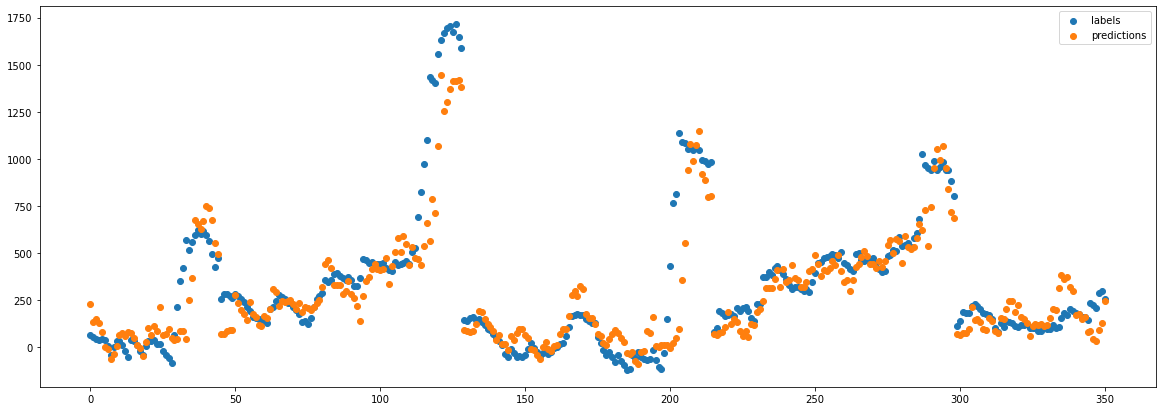

In [ ]:
from matplotlib import pyplot as plt

# adjust these numbers to change the width and height of the plot!
plt.rcParams["figure.figsize"] = [20, 7]

util.plot(69, 420, preds, labels)